# **앙상블(Ensemble): 개인실습용**

## **1. 라이브러리 로드**

In [42]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings(action='ignore') 

# 데이터 전처리 패키지
from sklearn.model_selection import train_test_split

# 모델 패키지
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

# 모델 평가 패키지
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import cross_val_score

# 시각화 패키지
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# 마이너스 기호(-) 깨짐 방지
matplotlib.rcParams['axes.unicode_minus'] = False

# # 한글 폰트 사용하기
# plt.rc('font', family='Malgun Gothic')

----------------------------------------------------------------------------------

## **2. 데이터 로드**

In [60]:
# 데이터 로드
df = pd.read_csv("titanic.csv")
df.shape

(891, 12)

In [61]:
# 데이터셋 확인
# defaut로 앞에서 5개의 데이터를 출력
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


1. PassengerId: 각 승객의 고유 식별자.
2. Survived: 생존 여부 (0 = 사망, 1 = 생존).
3. Pclass: 승객의 선실 등급 (1 = 1등급, 2 = 2등급, 3 = 3등급).
4. Name: 승객의 이름.
5. Sex: 승객의 성별 (male = 남성, female = 여성).
6. Age: 승객의 나이 (일부 값은 결측).
7. SibSp: 함께 탑승한 형제/자매 또는 배우자의 수.
8. Parch: 함께 탑승한 부모 또는 자녀의 수.
9. Ticket: 승객의 티켓 번호.
10. Fare: 승객이 지불한 요금.
11. Cabin: 승객의 객실 번호 (일부 값은 결측).
12. Embarked: 승객의 승선 항구 (C = Cherbourg, Q = Queenstown, S = Southampton).

In [62]:
# 각 column명 확인
df.keys()

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [63]:
# 데이터셋의 요약 정보 확인
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [64]:
# 결측치 확인
df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [65]:
# column 별 기본적인 통계 값 확인
df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [66]:
# 사용 안 할 변수(ex. Name, PassengerId, Ticket, Cabin..) 제거
print("Before", df.shape)

df = df.drop(["Name", "PassengerId", "Ticket", "Cabin"], axis = 1)

print("After", df.shape)
df

Before (891, 12)
After (891, 8)


,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S
...,...,...,...,...,...,...,...,...
886,0,2,male,27.0,0,0,13.0000,S
887,1,1,female,19.0,0,0,30.0000,S
888,0,3,female,NaN,1,2,23.4500,S
889,1,1,male,26.0,0,0,30.0000,C


In [67]:
# Age 결측치 제거 및 age와 embarked 채워넣기
df = df.dropna()
df.isnull().sum()

for col in df.columns:
    na = 'column: {:>10}\t Percent of NaN value: {:.2f}%'.format(col, 100 * (df[col].isnull().sum() / df[col].shape[0]))
    print(na)

column:   Survived	 Percent of NaN value: 0.00%
column:     Pclass	 Percent of NaN value: 0.00%
column:        Sex	 Percent of NaN value: 0.00%
column:        Age	 Percent of NaN value: 0.00%
column:      SibSp	 Percent of NaN value: 0.00%
column:      Parch	 Percent of NaN value: 0.00%
column:       Fare	 Percent of NaN value: 0.00%
column:   Embarked	 Percent of NaN value: 0.00%


In [68]:
# target과 x로 분리
data = df.drop(['Survived'], axis =1)
y = df['Survived']

----------------------------------------------------------------------------------

## **3. 데이터 전처리**

#### 3-1. x 레이블 인코딩
- 범주형 변수를 연속형 변수로 인코딩 하는 전처리 과정

In [71]:
# x,y레이블 인코딩 필요시
# Sex & Embarked변수 문자를 숫자로 변환
sex_mapping = {"male": 0, "female": 1}
embarked_mapping = {"S": 0, "C": 1, "Q": 2}

data["Sex"] = data["Sex"].map(sex_mapping).astype(int)
data["Embarked"] = data["Embarked"].fillna("S")
data["Embarked"] = data["Embarked"].map(embarked_mapping).astype(int)

data

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,0,22.0,1,0,7.2500,0
1,1,1,38.0,1,0,71.2833,1
2,3,1,26.0,0,0,7.9250,0
3,1,1,35.0,1,0,53.1000,0
4,3,0,35.0,0,0,8.0500,0
...,...,...,...,...,...,...,...
885,3,1,39.0,0,5,29.1250,2
886,2,0,27.0,0,0,13.0000,0
887,1,1,19.0,0,0,30.0000,0
889,1,0,26.0,0,0,30.0000,1


#### 3-2. train, validation 데이터 셋 분할
- train, test 데이터를 적당한 셋으로 분할

In [72]:
# 데이터 셋 분할
X_train, X_test, y_train, y_test = train_test_split(data, y, test_size=0.2, random_state=123)

----------------------------------------------------------------------------------

## **4. 모델 구축**

### **4-1. Bagging**

**(1) 모델 생성**

In [73]:
# 배깅 모델 불러오기
bagging = BaggingClassifier(DecisionTreeClassifier(),
                           n_estimators=500,
                           max_samples=1.0,
                           max_features=1.0,
                           bootstrap=True,
                           bootstrap_features=False,
                           random_state=1)
# 모델 학습
bagging.fit(X_train, y_train)

BaggingClassifier(estimator=DecisionTreeClassifier(), n_estimators=500,
                  random_state=1)

**(2) AUC 검정**

In [80]:
# 배깅 모델 불러오기
scores = cross_val_score(estimator=bagging, X=X_train, y=y_train, cv=10, scoring='roc_auc')
test_scores = cross_val_score(estimator=bagging, X=X_test, y=y_test, cv=10, scoring='roc_auc')
print("Train ROC AUC: %0.3f (+/- %0.3f) [%s]"%(scores.mean(),scores.std(),"Bagging"))
print("Test ROC AUC: %0.3f (+/- %0.3f) [%s]"%(test_scores.mean(),test_scores.std(),"Bagging"))

Train ROC AUC: 0.849 (+/- 0.048) [Bagging]
Test ROC AUC: 0.845 (+/- 0.116) [Bagging]


**(3) ROC 곡선 그리기**

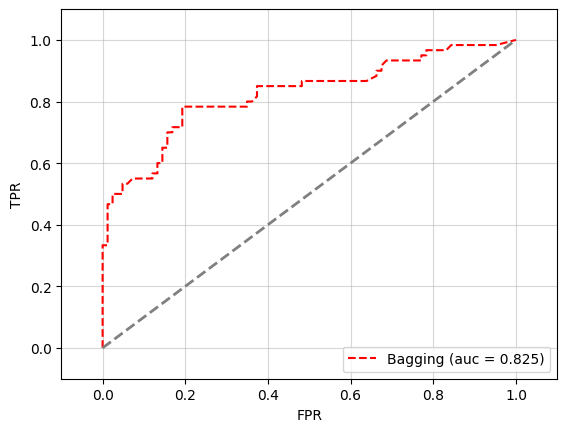

In [84]:
# 모델 예측
y_pred = bagging.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_true=y_test, y_score=y_pred)
roc_auc = auc(x=fpr, y=tpr)
plt.plot(fpr, tpr, 'r--', label='%s (auc = %0.3f)'%('Bagging', roc_auc))
    
plt.legend(loc='lower right')
plt.plot([0,1],[0,1], linestyle='--', color='gray', linewidth=2)
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.grid(alpha=0.5)
plt.xlabel('FPR')
plt.ylabel('TPR')

plt.show()

**(4) confusion matrix**

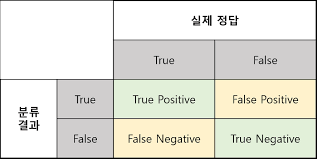

<Axes: >

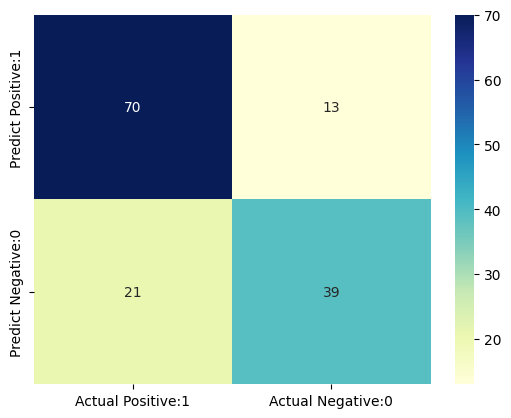

In [85]:
# matrix 생성
y_pred = bagging.predict(X_test)
# Confusion Matrix 출력
cm = confusion_matrix(y_test, y_pred)
cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive:1', 'Actual Negative:0'], 
                                 index=['Predict Positive:1', 'Predict Negative:0'])

sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')

In [86]:
# 정확도 정밀도, 재현율, F1 출력
print('잘못 분류된 샘플 개수 : %d'%(y_test != y_pred).sum())
print('정확도 : %.3f'%accuracy_score(y_test, y_pred))
print('정밀도 : %.3f'%precision_score(y_true=y_test, y_pred=y_pred))
print('재현율 : %.3f'%recall_score(y_true=y_test, y_pred=y_pred))
print('F1 : %.3f'%f1_score(y_true=y_test, y_pred=y_pred))

잘못 분류된 샘플 개수 : 34
정확도 : 0.762
정밀도 : 0.750
재현율 : 0.650
F1 : 0.696


### **4-2. RandomForest**

**(1) 모델 생성**

In [87]:
# 랜덤포레스트 모델 불러오기
forest = RandomForestClassifier(criterion='gini',
                           n_estimators=500,
                           random_state=1)
# 모델 학습
forest.fit(X_train, y_train)

RandomForestClassifier(n_estimators=500, random_state=1)

**(2) AUC 검정**

In [89]:
# AUC 검정
scores = cross_val_score(estimator=forest, X=X_train, y=y_train, cv=10, scoring='roc_auc')
test_scores = cross_val_score(estimator=forest, X=X_test, y=y_test, cv=10, scoring='roc_auc')
print("Train ROC AUC: %0.3f (+/- %0.3f) [%s]"%(scores.mean(),scores.std(),"Bagging"))
print("Test ROC AUC: %0.3f (+/- %0.3f) [%s]"%(test_scores.mean(),test_scores.std(),"Bagging"))

Train ROC AUC: 0.858 (+/- 0.045) [Bagging]
Test ROC AUC: 0.839 (+/- 0.095) [Bagging]


**(3) ROC 곡선 그리기**

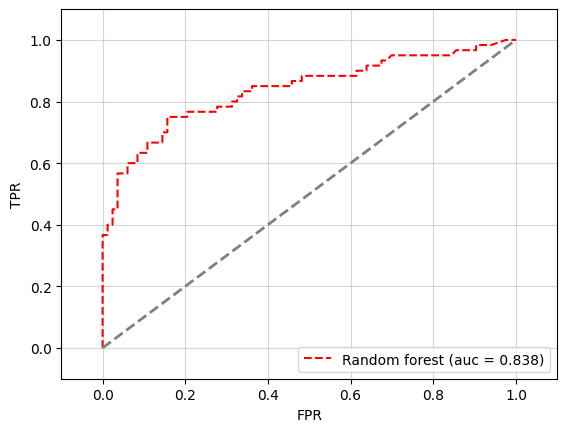

In [90]:
# ROC curve 그리기
forest.fit(X_train, y_train)
y_pred = forest.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_true=y_test, y_score=y_pred)
roc_auc = auc(x=fpr, y=tpr)
plt.plot(fpr, tpr, 'r--', label='%s (auc = %0.3f)'%('Random forest', roc_auc))
    
plt.legend(loc='lower right')
plt.plot([0,1],[0,1], linestyle='--', color='gray', linewidth=2)
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.grid(alpha=0.5)
plt.xlabel('FPR')
plt.ylabel('TPR')

plt.show()

**(4) confusion matrix**

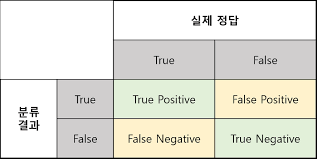

<Axes: >

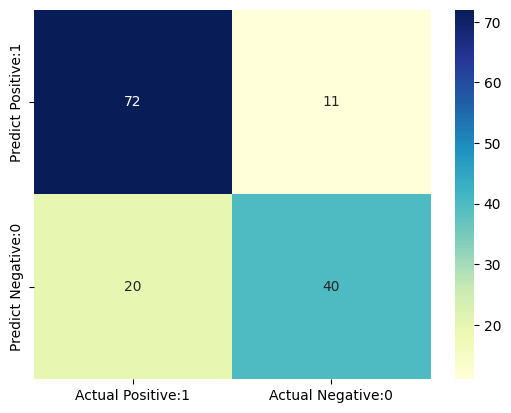

In [91]:
# matrix 생성
forest.fit(X_train, y_train)
y_pred = forest.predict(X_test)

# Confusion Matrix 출력
cm = confusion_matrix(y_test, y_pred)
cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive:1', 'Actual Negative:0'], 
                                 index=['Predict Positive:1', 'Predict Negative:0'])

sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')

In [92]:
# 정확도 정밀도, 재현율, F1 출력
print('잘못 분류된 샘플 개수 : %d'%(y_test != y_pred).sum())
print('정확도 : %.3f'%accuracy_score(y_test, y_pred))
print('정밀도 : %.3f'%precision_score(y_true=y_test, y_pred=y_pred))
print('재현율 : %.3f'%recall_score(y_true=y_test, y_pred=y_pred))
print('F1 : %.3f'%f1_score(y_true=y_test, y_pred=y_pred))

잘못 분류된 샘플 개수 : 31
정확도 : 0.783
정밀도 : 0.784
재현율 : 0.667
F1 : 0.721


### **4-3. AdaBoost**

**(1) 모델 생성**

In [93]:
# AdaBoost 모델 불러오기
adaboost = AdaBoostClassifier(DecisionTreeClassifier(),
                                n_estimators=500,
                                learning_rate = 0.1,
                                random_state=1)
# 모델 학습
adaboost.fit(X_train, y_train)
# 모델 예측
y_pred = adaboost.predict(X_test)

**(2) AUC 검정**

In [94]:
# AUC 검정
scores = cross_val_score(estimator=adaboost, X=X_train, y=y_train, cv=10, scoring='roc_auc')
test_scores = cross_val_score(estimator=adaboost, X=X_test, y=y_test, cv=10, scoring='roc_auc')
print("Train ROC AUC: %0.3f (+/- %0.3f) [%s]"%(scores.mean(),scores.std(),"Bagging"))
print("Test ROC AUC: %0.3f (+/- %0.3f) [%s]"%(test_scores.mean(),test_scores.std(),"Bagging"))

Train ROC AUC: 0.800 (+/- 0.052) [Bagging]
Test ROC AUC: 0.751 (+/- 0.115) [Bagging]


**(3) ROC 곡선 그리기**

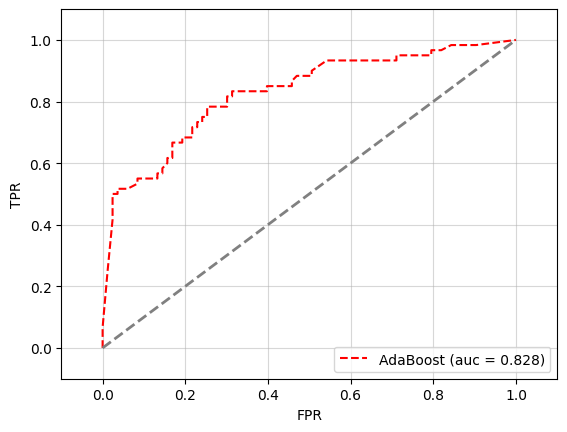

In [95]:
# ROC curve 그리기
y_pred = adaboost.predict_proba(X_test)[:,1]
# ROC curve 그리기
fpr, tpr, thresholds = roc_curve(y_true=y_test, y_score=y_pred)
roc_auc = auc(x=fpr, y=tpr)
plt.plot(fpr, tpr, 'r--', label='%s (auc = %0.3f)'%('AdaBoost', roc_auc))
    
plt.legend(loc='lower right')
plt.plot([0,1],[0,1], linestyle='--', color='gray', linewidth=2)
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.grid(alpha=0.5)
plt.xlabel('FPR')
plt.ylabel('TPR')

plt.show()

**(4) confusion matrix**

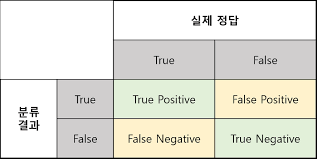

<Axes: >

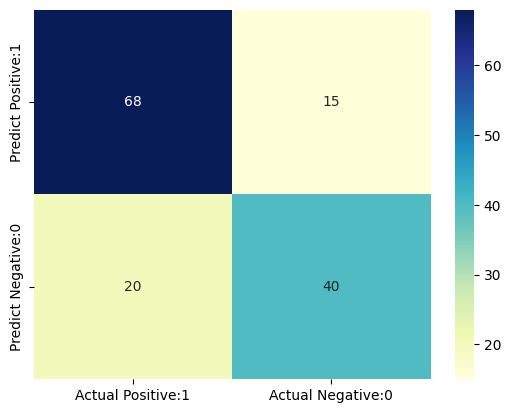

In [96]:
# matrix 생성
y_pred = adaboost.predict(X_test)

# Confusion Matrix 출력
cm = confusion_matrix(y_test, y_pred)
cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive:1', 'Actual Negative:0'], 
                                 index=['Predict Positive:1', 'Predict Negative:0'])

sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')

In [97]:
# 정확도 정밀도, 재현율, F1 출력
print('잘못 분류된 샘플 개수 : %d'%(y_test != y_pred).sum())
print('정확도 : %.3f'%accuracy_score(y_test, y_pred))
print('정밀도 : %.3f'%precision_score(y_true=y_test, y_pred=y_pred))
print('재현율 : %.3f'%recall_score(y_true=y_test, y_pred=y_pred))
print('F1 : %.3f'%f1_score(y_true=y_test, y_pred=y_pred))

잘못 분류된 샘플 개수 : 35
정확도 : 0.755
정밀도 : 0.727
재현율 : 0.667
F1 : 0.696


### **4-4. Gradient Boosting**

**(1) 모델 생성**

In [98]:
# Gradient Boosting 모델 불러오기
gbm = GradientBoostingClassifier(n_estimators=500,
                                learning_rate = 0.1,
                                random_state=1)
# 모델 학습
gbm.fit(X_train, y_train)

GradientBoostingClassifier(n_estimators=500, random_state=1)

**(2) AUC 검정**

In [99]:
# AUC 검정
scores = cross_val_score(estimator=gbm, X=X_train, y=y_train, cv=10, scoring='roc_auc')
test_scores = cross_val_score(estimator=gbm, X=X_test, y=y_test, cv=10, scoring='roc_auc')
print("Train ROC AUC: %0.3f (+/- %0.3f) [%s]"%(scores.mean(),scores.std(),"Bagging"))
print("Test ROC AUC: %0.3f (+/- %0.3f) [%s]"%(test_scores.mean(),test_scores.std(),"Bagging"))

Train ROC AUC: 0.848 (+/- 0.046) [Bagging]
Test ROC AUC: 0.781 (+/- 0.120) [Bagging]


**(3) ROC 곡선 그리기**

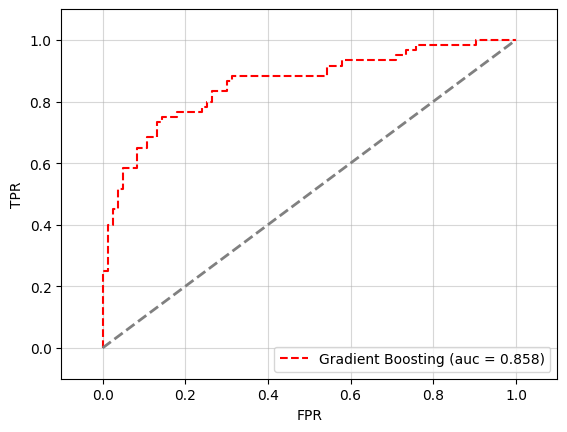

In [100]:
# ROC curve 그리기
y_pred = gbm.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_true=y_test, y_score=y_pred)
roc_auc = auc(x=fpr, y=tpr)
plt.plot(fpr, tpr, 'r--', label='%s (auc = %0.3f)'%('Gradient Boosting', roc_auc))
    
plt.legend(loc='lower right')
plt.plot([0,1],[0,1], linestyle='--', color='gray', linewidth=2)
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.grid(alpha=0.5)
plt.xlabel('FPR')
plt.ylabel('TPR')

plt.show()

**(4) confusion matrix**

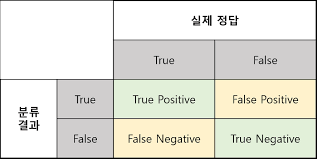

<Axes: >

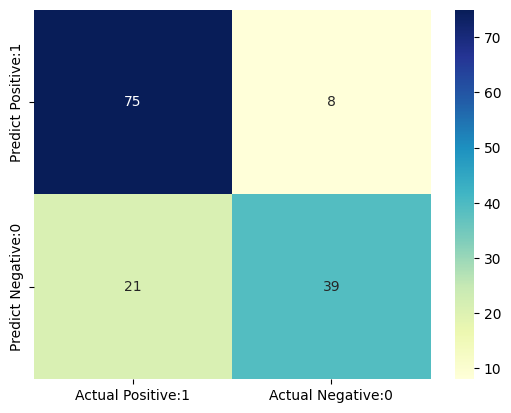

In [101]:
# matrix 생성
y_pred = gbm.predict(X_test)

# Confusion Matrix 출력
cm = confusion_matrix(y_test, y_pred)
cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive:1', 'Actual Negative:0'], 
                                 index=['Predict Positive:1', 'Predict Negative:0'])

sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')

In [102]:
# 정확도 정밀도, 재현율, F1 출력
print('잘못 분류된 샘플 개수 : %d'%(y_test != y_pred).sum())
print('정확도 : %.3f'%accuracy_score(y_test, y_pred))
print('정밀도 : %.3f'%precision_score(y_true=y_test, y_pred=y_pred))
print('재현율 : %.3f'%recall_score(y_true=y_test, y_pred=y_pred))
print('F1 : %.3f'%f1_score(y_true=y_test, y_pred=y_pred))

잘못 분류된 샘플 개수 : 29
정확도 : 0.797
정밀도 : 0.830
재현율 : 0.650
F1 : 0.729


### **4-5. XGBoost**

**(1) 모델 생성**

In [103]:
# Gradient Boosting 모델 불러오기
xgb =  XGBClassifier(n_estimators=500,
                     learning_rate = 0.1,
                     random_state=1)
# 모델 학습
xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=500, n_jobs=None,
              num_parallel_tree=None, random_state=1, ...)

**(2) AUC 검정**

In [104]:
# AUC 검정
scores = cross_val_score(estimator=xgb, X=X_train, y=y_train, cv=10, scoring='roc_auc')
test_scores = cross_val_score(estimator=xgb, X=X_test, y=y_test, cv=10, scoring='roc_auc')
print("Train ROC AUC: %0.3f (+/- %0.3f) [%s]"%(scores.mean(),scores.std(),"Bagging"))
print("Test ROC AUC: %0.3f (+/- %0.3f) [%s]"%(test_scores.mean(),test_scores.std(),"Bagging"))

Train ROC AUC: 0.850 (+/- 0.046) [Bagging]
Test ROC AUC: 0.837 (+/- 0.130) [Bagging]


**ROC 곡선 그리기**

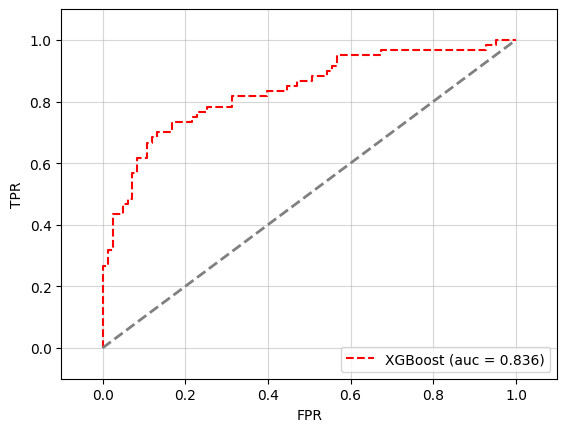

In [105]:
# ROC curve 그리기
y_pred = xgb.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_true=y_test, y_score=y_pred)
roc_auc = auc(x=fpr, y=tpr)
plt.plot(fpr, tpr, 'r--', label='%s (auc = %0.3f)'%('XGBoost', roc_auc))
    
plt.legend(loc='lower right')
plt.plot([0,1],[0,1], linestyle='--', color='gray', linewidth=2)
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.grid(alpha=0.5)
plt.xlabel('FPR')
plt.ylabel('TPR')

plt.show()

**(4) confusion matrix**

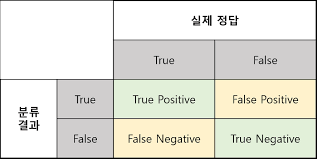

<Axes: >

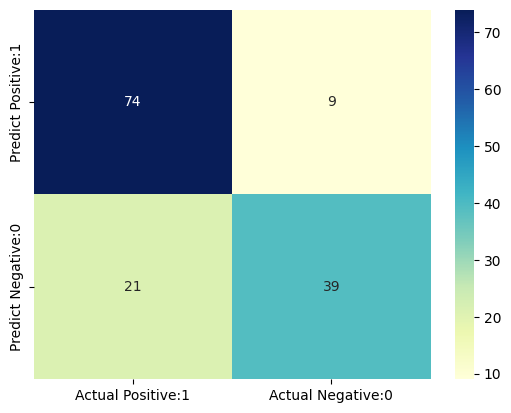

In [106]:
# matrix 생성
y_pred = xgb.predict(X_test)#### matrix로 검정

# Confusion Matrix 출력
cm = confusion_matrix(y_test, y_pred)
cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive:1', 'Actual Negative:0'], 
                                 index=['Predict Positive:1', 'Predict Negative:0'])

sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')

In [107]:
# 정확도 정밀도, 재현율, F1 출력
print('잘못 분류된 샘플 개수 : %d'%(y_test != y_pred).sum())
print('정확도 : %.3f'%accuracy_score(y_test, y_pred))
print('정밀도 : %.3f'%precision_score(y_true=y_test, y_pred=y_pred))
print('재현율 : %.3f'%recall_score(y_true=y_test, y_pred=y_pred))
print('F1 : %.3f'%f1_score(y_true=y_test, y_pred=y_pred))

잘못 분류된 샘플 개수 : 30
정확도 : 0.790
정밀도 : 0.812
재현율 : 0.650
F1 : 0.722


### **4-6. LightGBM**

**(1) 모델 생성**

In [108]:
# LightGBM 모델 불러오기
lgb = LGBMClassifier(n_estimators=500,
                     learning_rate = 0.1,
                     random_state=1)
# 모델 학습
lgb.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 228, number of negative: 341
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001974 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 187
[LightGBM] [Info] Number of data points in the train set: 569, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.400703 -> initscore=-0.402537
[LightGBM] [Info] Start training from score -0.402537
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


LGBMClassifier(n_estimators=500, random_state=1)

**(2) AUC 검정**

In [109]:
# AUC 검정
scores = cross_val_score(estimator=lgb, X=X_train, y=y_train, cv=10, scoring='roc_auc')
test_scores = cross_val_score(estimator=lgb, X=X_test, y=y_test, cv=10, scoring='roc_auc')
print("Train ROC AUC: %0.3f (+/- %0.3f) [%s]"%(scores.mean(),scores.std(),"Bagging"))
print("Test ROC AUC: %0.3f (+/- %0.3f) [%s]"%(test_scores.mean(),test_scores.std(),"Bagging"))

[LightGBM] [Info] Number of positive: 205, number of negative: 307
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000232 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 173
[LightGBM] [Info] Number of data points in the train set: 512, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.400391 -> initscore=-0.403838
[LightGBM] [Info] Start training from score -0.403838
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


**(3) ROC 곡선 그리기**

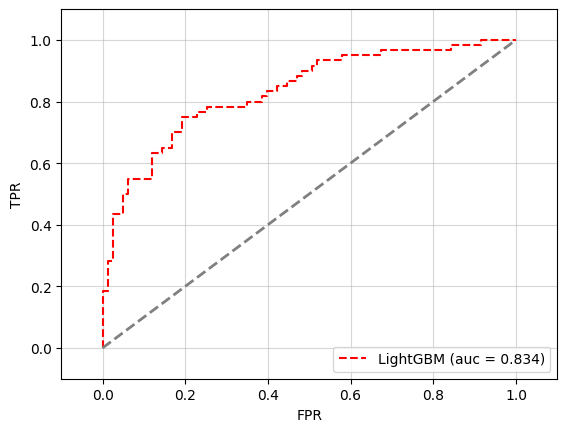

In [110]:
# ROC curve 그리기
y_pred = lgb.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_true=y_test, y_score=y_pred)
roc_auc = auc(x=fpr, y=tpr)
plt.plot(fpr, tpr, 'r--', label='%s (auc = %0.3f)'%('LightGBM', roc_auc))
    
plt.legend(loc='lower right')
plt.plot([0,1],[0,1], linestyle='--', color='gray', linewidth=2)
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.grid(alpha=0.5)
plt.xlabel('FPR')
plt.ylabel('TPR')

plt.show()

**(4) confusion matrix**

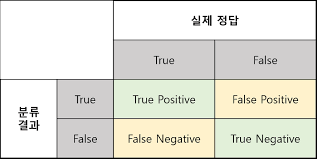

<Axes: >

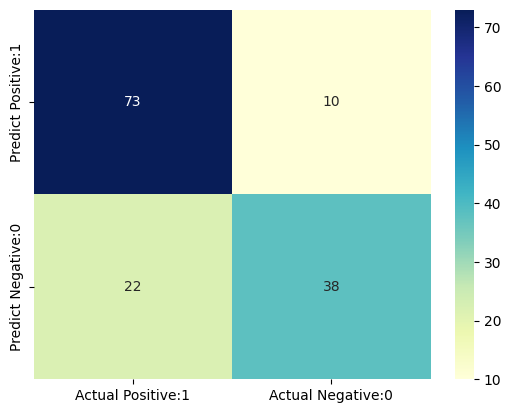

In [111]:
# matrix 생성
y_pred = lgb.predict(X_test)

# Confusion Matrix 출력
cm = confusion_matrix(y_test, y_pred)
cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive:1', 'Actual Negative:0'], 
                                 index=['Predict Positive:1', 'Predict Negative:0'])

sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')

In [112]:
# 정확도 정밀도, 재현율, F1 출력
print('잘못 분류된 샘플 개수 : %d'%(y_test != y_pred).sum())
print('정확도 : %.3f'%accuracy_score(y_test, y_pred))
print('정밀도 : %.3f'%precision_score(y_true=y_test, y_pred=y_pred))
print('재현율 : %.3f'%recall_score(y_true=y_test, y_pred=y_pred))
print('F1 : %.3f'%f1_score(y_true=y_test, y_pred=y_pred))

잘못 분류된 샘플 개수 : 32
정확도 : 0.776
정밀도 : 0.792
재현율 : 0.633
F1 : 0.704


### **4-7. CatBoost**

**(1) 모델 생성**

In [113]:
# CatBoost 모델 불러오기
catb = CatBoostClassifier(n_estimators=500,
                                learning_rate = 0.1,
                                random_state=1)
# 모델 학습
catb.fit(X_train, y_train)

0:	learn: 0.6378361	total: 161ms	remaining: 1m 20s
1:	learn: 0.6092518	total: 164ms	remaining: 40.7s
2:	learn: 0.5719959	total: 166ms	remaining: 27.5s
3:	learn: 0.5361923	total: 174ms	remaining: 21.6s
4:	learn: 0.5124056	total: 179ms	remaining: 17.7s
5:	learn: 0.4953994	total: 184ms	remaining: 15.1s
6:	learn: 0.4876616	total: 199ms	remaining: 14s
7:	learn: 0.4751542	total: 203ms	remaining: 12.5s
8:	learn: 0.4702369	total: 208ms	remaining: 11.4s
9:	learn: 0.4613460	total: 214ms	remaining: 10.5s
10:	learn: 0.4437181	total: 224ms	remaining: 9.95s
11:	learn: 0.4331900	total: 229ms	remaining: 9.33s
12:	learn: 0.4247151	total: 276ms	remaining: 10.4s
13:	learn: 0.4167819	total: 281ms	remaining: 9.74s
14:	learn: 0.4100061	total: 286ms	remaining: 9.25s
15:	learn: 0.4034799	total: 349ms	remaining: 10.5s
16:	learn: 0.3970866	total: 392ms	remaining: 11.1s
17:	learn: 0.3927849	total: 402ms	remaining: 10.8s
18:	learn: 0.3873858	total: 469ms	remaining: 11.9s
19:	learn: 0.3830856	total: 482ms	remainin

**(2) AUC 검정**

In [114]:
# AUC 검정
scores = cross_val_score(estimator=catb, X=X_train, y=y_train, cv=10, scoring='roc_auc')
test_scores = cross_val_score(estimator=catb, X=X_test, y=y_test, cv=10, scoring='roc_auc')
print("Train ROC AUC: %0.3f (+/- %0.3f) [%s]"%(scores.mean(),scores.std(),"Bagging"))
print("Test ROC AUC: %0.3f (+/- %0.3f) [%s]"%(test_scores.mean(),test_scores.std(),"Bagging"))

0:	learn: 0.6343168	total: 5.87ms	remaining: 2.93s
1:	learn: 0.6067469	total: 10.7ms	remaining: 2.67s
2:	learn: 0.5684886	total: 14.2ms	remaining: 2.35s
3:	learn: 0.5315172	total: 28ms	remaining: 3.47s
4:	learn: 0.5108159	total: 32.5ms	remaining: 3.22s
5:	learn: 0.4817640	total: 46.9ms	remaining: 3.86s
6:	learn: 0.4733624	total: 51.7ms	remaining: 3.64s
7:	learn: 0.4547276	total: 60.2ms	remaining: 3.7s
8:	learn: 0.4375927	total: 65.1ms	remaining: 3.55s
9:	learn: 0.4237198	total: 81.3ms	remaining: 3.98s
10:	learn: 0.4133225	total: 89.1ms	remaining: 3.96s
11:	learn: 0.4096962	total: 91.5ms	remaining: 3.72s
12:	learn: 0.3995435	total: 96.1ms	remaining: 3.6s
13:	learn: 0.3960509	total: 106ms	remaining: 3.67s
14:	learn: 0.3884505	total: 112ms	remaining: 3.63s
15:	learn: 0.3812100	total: 118ms	remaining: 3.56s
16:	learn: 0.3775063	total: 122ms	remaining: 3.48s
17:	learn: 0.3720646	total: 126ms	remaining: 3.38s
18:	learn: 0.3661511	total: 131ms	remaining: 3.32s
19:	learn: 0.3635316	total: 136m

**(3) ROC 곡선 그리기**

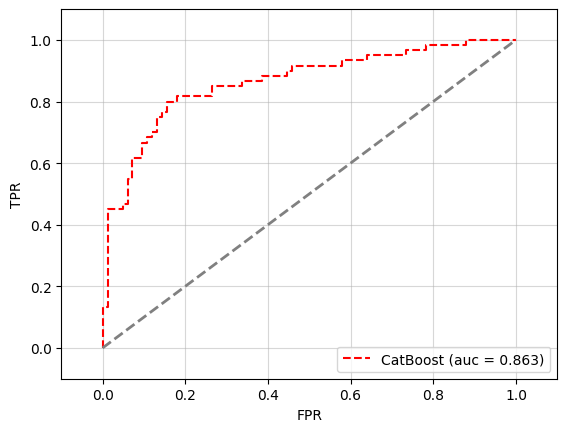

In [115]:
# ROC curve 그리기
y_pred = catb.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_true=y_test, y_score=y_pred)
roc_auc = auc(x=fpr, y=tpr)
plt.plot(fpr, tpr, 'r--', label='%s (auc = %0.3f)'%('CatBoost', roc_auc))
    
plt.legend(loc='lower right')
plt.plot([0,1],[0,1], linestyle='--', color='gray', linewidth=2)
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.grid(alpha=0.5)
plt.xlabel('FPR')
plt.ylabel('TPR')

plt.show()

**(4) confusion matrix**

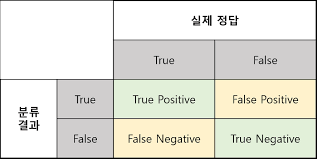

<Axes: >

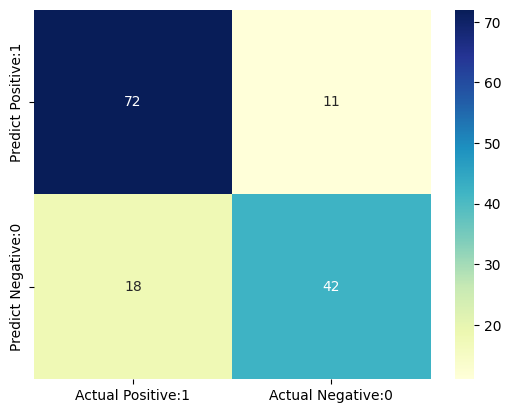

In [116]:
# matrix 생성
y_pred = catb.predict(X_test)#### matrix로 검정

# Confusion Matrix 출력
cm = confusion_matrix(y_test, y_pred)
cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive:1', 'Actual Negative:0'], 
                                 index=['Predict Positive:1', 'Predict Negative:0'])

sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')

In [117]:
# 정확도 정밀도, 재현율, F1 출력
print('잘못 분류된 샘플 개수 : %d'%(y_test != y_pred).sum())
print('정확도 : %.3f'%accuracy_score(y_test, y_pred))
print('정밀도 : %.3f'%precision_score(y_true=y_test, y_pred=y_pred))
print('재현율 : %.3f'%recall_score(y_true=y_test, y_pred=y_pred))
print('F1 : %.3f'%f1_score(y_true=y_test, y_pred=y_pred))

잘못 분류된 샘플 개수 : 29
정확도 : 0.797
정밀도 : 0.792
재현율 : 0.700
F1 : 0.743


## **5.  7개 모델 비교**

**(1) AUC 검정**

In [118]:
# 7개의 모델
clf_labels = ["Bagging", "Random forest", "AdaBoost", "Gradient Boosting", "XGBoost", "LightGBM", 'CatBoost']
all_clf = [bagging, forest, adaboost, gbm, xgb, lgb, catb]

In [119]:
# AUC 검정
for clf, label in zip(all_clf, clf_labels):
    scores = cross_val_score(estimator=clf,
                            X=X_test,
                            y=y_test,
                            cv=10,
                            scoring='roc_auc')
    print("ROC AUC: %0.3f (+/- %0.3f) [%s]"%(scores.mean(),scores.std(), label))

ROC AUC: 0.845 (+/- 0.116) [Bagging]
ROC AUC: 0.839 (+/- 0.095) [Random forest]
ROC AUC: 0.751 (+/- 0.115) [AdaBoost]
ROC AUC: 0.781 (+/- 0.120) [Gradient Boosting]
ROC AUC: 0.837 (+/- 0.130) [XGBoost]
[LightGBM] [Info] Number of positive: 54, number of negative: 74
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000152 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 83
[LightGBM] [Info] Number of data points in the train set: 128, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.421875 -> initscore=-0.315081
[LightGBM] [Info] Start training from score -0.315081
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No fu

[LightGBM] [Info] Number of positive: 228, number of negative: 341
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000132 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 187
[LightGBM] [Info] Number of data points in the train set: 569, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.400703 -> initscore=-0.402537
[LightGBM] [Info] Start training from score -0.402537
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


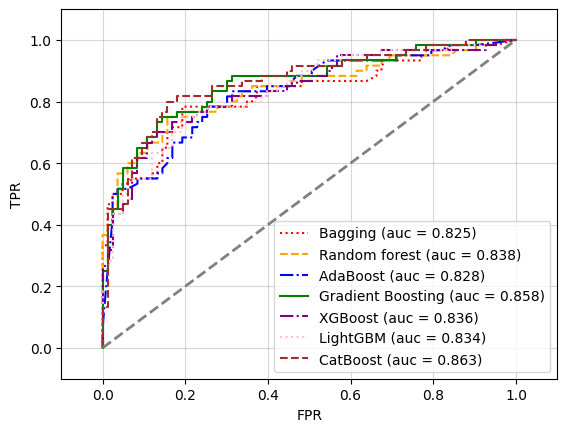

In [120]:
# ROC curve 그리기
colors = ['red','orange','blue','green','purple','pink','brown']
linestyles = [':','--','-.','-','-.',':','--']

for clf, label, clr, ls in zip(all_clf, clf_labels, colors, linestyles):
    clf.fit(X_train, y_train)
    y_pred = clf.predict_proba(X_test)[:,1]
    fpr, tpr, thresholds = roc_curve(y_true=y_test,
                                    y_score=y_pred)
    roc_auc = auc(x=fpr, y=tpr)
    plt.plot(fpr, tpr, color=clr, linestyle=ls, label='%s (auc = %0.3f)'%(label, roc_auc))
    
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],
        linestyle='--',
        color='gray',
        linewidth=2)
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.grid(alpha=0.5)
plt.xlabel('FPR')
plt.ylabel('TPR')

plt.show()